## Author: SUBHANI SHAIK -MT18117

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy,pickle,glob,warnings
from prettytable import PrettyTable

from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,f1_score,precision_score,recall_score,precision_recall_curve,matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier

from sklearn.decomposition import TruncatedSVD
from genetic_selection import GeneticSelectionCV
from copy import deepcopy

warnings.filterwarnings('ignore')

In [2]:
def draw_roc(y_actual, scores, title=''):
    fpr, tpr, thresholds = roc_curve(y_actual, scores, pos_label=1)
    auroc_value = auc(fpr, tpr)

    plt.plot(fpr,tpr, label = 'AUC: '+str(round(auroc_value, 4)))
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR = 1-Specificity')
    plt.ylabel("TPR = Recall = Sensitivity")
    plt.title("AUC-ROC Curve: " + title)
    plt.legend(loc = 'lower right')
    plt.savefig(title+'-ROC')
    return auroc_value
    
def metric(y_test, y_pred,scores, title=''):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity, acc, f1, precision, recall, mcc = tn/(tn + fp) ,accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), matthews_corrcoef(y_test, y_pred)
    
    x,metric_list = PrettyTable(), []
    
    x.field_names = ["Evaluation Metric", "Score"]; 
    x.add_row(["Accuracy", round(acc, 4)]); metric_list.append(["Accuracy",round(acc, 4)])
    x.add_row(["F1-score", round(f1, 4)]); metric_list.append(['F1-score',round(f1, 4)])
    x.add_row(["Precision", round(precision, 4)]); metric_list.append(['Precision', round(precision, 4)])
    x.add_row(["Recall", round(recall, 4)]); metric_list.append(["Recall", round(recall, 4)])
    x.add_row(["Specificity", round(specificity, 4)]); metric_list.append(["Specificity", round(specificity, 4)])
    x.add_row(["MCC", round(mcc, 4)]); metric_list.append(["MCC", round(mcc, 4)])
    
    auroc_value = draw_roc(y_test,scores, title)
    x.add_row(["AUROC value", round(auroc_value, 4)]); metric_list.append(["AUROC value", round(auroc_value, 4)])
    
    print(x);plt.show()
    print('--------------------------------------------------------------\n\n\n')
    return metric_list

### Models

In [3]:
def model_logistic_regression(X_train, X_test, y_train, y_test):
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**-1, 10**0,10**1, 10**2, 10**4]}]
    logistic_model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
    logistic_model.fit(X_train, y_train)

    logistic_train_pred, logistic_test_pred = logistic_model.predict(X_train), logistic_model.predict(X_test)
    logistic_train_scores, logistic_test_scores = logistic_model.predict_proba(X_train)[:,1], logistic_model.predict_proba(X_test)[:,1]

    print('Logistic Regression')
    logistic_metric_list_train, logistic_metric_list_test = metric(y_train, logistic_train_pred, logistic_train_scores, 'Logistic Regression(Train metrics)'),\
                                                            metric(y_test, logistic_test_pred, logistic_test_scores, 'Logistic Regression(Test metrics)')

    return logistic_model, logistic_metric_list_train, logistic_metric_list_test

def model_rbfsvm(X_train, X_test, y_train, y_test):
    
    Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
    gammas = [0.0001,0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}

    rbfsvm_model = GridSearchCV(SVC(kernel='rbf',probability=True), param_grid, cv=5)
    rbfsvm_model.fit(X_train, y_train)

    rbfsvm_train_pred, rbfsvm_test_pred = rbfsvm_model.predict(X_train), rbfsvm_model.predict(X_test)

    rbfsvm_train_scores, rbfsvm_test_scores = rbfsvm_model.predict_proba(X_train)[:,1], rbfsvm_model.predict_proba(X_test)[:,1]

    print('SVM(kernel=RBF) classifier')
    rbfsvm_metric_list_train, rbfsvm_metric_list_test = metric(y_train, rbfsvm_train_pred, rbfsvm_train_scores, 'SVM(Train metrics)'),\
                                                        metric(y_test, rbfsvm_test_pred, rbfsvm_test_scores, 'SVM (Test metrics)')

    return rbfsvm_model, rbfsvm_metric_list_train, rbfsvm_metric_list_test

def model_dTree_1(X_train, X_test, y_train, y_test):
    depth = np.linspace(1, 15, 15, endpoint=True)
    min_split = np.linspace(0.5, 1.0, 10, endpoint=True)
    min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
    max_feat = list(range(1,X_train.shape[1]))
    param_grid = {'max_depth': depth, 'min_samples_split' : min_split,'min_samples_leaf' : min_samples_leaf,'max_features' : max_feat}

    dtree_model = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    dtree_model.fit(X_train, y_train)

    dtree_train_pred, dtree_test_pred = dtree_model.predict(X_train), dtree_model.predict(X_test)
    dtree_train_scores, dtree_test_scores = dtree_model.predict_proba(X_train)[:,1], dtree_model.predict_proba(X_test)[:,1]

    print('DecisionTree classifier')
    dtree_metric_list_train, dtree_metric_list_test = metric(y_train, dtree_train_pred, dtree_train_scores, 'DecisionTree(Train metrics)'),\
                                                    metric(y_test, dtree_test_pred, dtree_test_scores, 'DecisionTree(Test metrics)')

    return dtree_model, dtree_metric_list_train, dtree_metric_list_test

def model_dTree_2(X_train, X_test, y_train, y_test):
    depth = np.linspace(1, 15, 15, endpoint=True)
#     min_split = np.linspace(0.5, 1.0, 10, endpoint=True)
#     min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
    max_feat = list(range(1,X_train.shape[1]))
#     param_grid = {'max_depth': depth, 'min_samples_split' : min_split,'min_samples_leaf' : min_samples_leaf,'max_features' : max_feat}
    param_grid = {'max_depth': depth,'max_features' : max_feat}
    dtree_model = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    dtree_model.fit(X_train, y_train)

    dtree_train_pred, dtree_test_pred = dtree_model.predict(X_train), dtree_model.predict(X_test)
    dtree_train_scores, dtree_test_scores = dtree_model.predict_proba(X_train)[:,1], dtree_model.predict_proba(X_test)[:,1]

    print('DecisionTree classifier')
    dtree_metric_list_train, dtree_metric_list_test = metric(y_train, dtree_train_pred, dtree_train_scores, 'DecisionTree(Train metrics)'),\
                                                    metric(y_test, dtree_test_pred, dtree_test_scores, 'DecisionTree(Test metrics)')

    return dtree_model, dtree_metric_list_train, dtree_metric_list_test

def model_dTree_3(X_train, X_test, y_train, y_test):
    dtree_model = DecisionTreeClassifier()
    dtree_model.fit(X_train, y_train)

    dtree_train_pred, dtree_test_pred = dtree_model.predict(X_train), dtree_model.predict(X_test)
    dtree_train_scores, dtree_test_scores = dtree_model.predict_proba(X_train)[:,1], dtree_model.predict_proba(X_test)[:,1]

    print('DecisionTree classifier')
    dtree_metric_list_train, dtree_metric_list_test = metric(y_train, dtree_train_pred, dtree_train_scores, 'DecisionTree(Train metrics)'),\
                                                    metric(y_test, dtree_test_pred, dtree_test_scores, 'DecisionTree(Test metrics)')

    return dtree_model, dtree_metric_list_train, dtree_metric_list_test

def model_mlp(X_train, X_test, y_train, y_test, layer1, layer2):
    mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(layer1,layer2), random_state=42)
    mlp_model.fit(X_train, y_train)

    mlp_train_pred, mlp_test_pred = mlp_model.predict(X_train), mlp_model.predict(X_test)
    mlp_train_scores, mlp_test_scores = mlp_model.predict_proba(X_train)[:,1], mlp_model.predict_proba(X_test)[:,1]

    print('MLP classifier')
    mlp_metric_list_train, mlp_metric_list_test = metric(y_train, mlp_train_pred, mlp_train_scores, 'MLP(Train metrics)'),\
                                                    metric(y_test, mlp_test_pred, mlp_test_scores, 'MLP(Test metrics)')

    return mlp_model, mlp_metric_list_train, mlp_metric_list_test

def model_random_forest_1(X_train, X_test, y_train, y_test):
    depth = np.linspace(1, 32, 32, endpoint=True)
    min_split = np.linspace(0.1, 1.0, 10, endpoint=True)
    min_samples_lef = np.linspace(0.1, 0.5, 5, endpoint=True)
    est = [20,21,22,23,24,25,26]
    param_grid = {'n_estimators' : est,'max_depth': depth, 'min_samples_split' : min_split,'min_samples_leaf' : min_samples_lef}
    rf_model = GridSearchCV(RandomForestClassifier(), param_grid, cv=2,n_jobs=-1)
    rf_model.fit(X_train, y_train)

    rf_train_pred, rf_test_pred = rf_model.predict(X_train), rf_model.predict(X_test)
    rf_train_scores, rf_test_scores = rf_model.predict_proba(X_train)[:,1], rf_model.predict_proba(X_test)[:,1]

    print('Random Forest classifier')
    rf_metric_list_train, rf_metric_list_test = metric(y_train, rf_train_pred, rf_train_scores, 'Random Forest(Train)'),\
                                                metric(y_test, rf_test_pred, rf_test_scores, 'Random Forest(Test)')
    
    return rf_model, rf_metric_list_train, rf_metric_list_test

def model_random_forest_2(X_train, X_test, y_train, y_test):
    depth = np.linspace(1, 32, 32, endpoint=True)
    est = [20,21,22,23,24]
    param_grid = {'n_estimators' : est,'max_depth': depth}
    rf_model = GridSearchCV(RandomForestClassifier(), param_grid, cv=2,n_jobs=-1)
    rf_model.fit(X_train, y_train)

    rf_train_pred, rf_test_pred = rf_model.predict(X_train), rf_model.predict(X_test)
    rf_train_scores, rf_test_scores = rf_model.predict_proba(X_train)[:,1], rf_model.predict_proba(X_test)[:,1]

    print('Random Forest classifier')
    rf_metric_list_train, rf_metric_list_test = metric(y_train, rf_train_pred, rf_train_scores, 'Random Forest(Train)'),\
                                                metric(y_test, rf_test_pred, rf_test_scores, 'Random Forest(Test)')
    
    return rf_model, rf_metric_list_train, rf_metric_list_test

def model_random_forest_3(X_train, X_test, y_train, y_test):
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    rf_train_pred, rf_test_pred = rf_model.predict(X_train), rf_model.predict(X_test)
    rf_train_scores, rf_test_scores = rf_model.predict_proba(X_train)[:,1], rf_model.predict_proba(X_test)[:,1]

    print('Random Forest classifier')
    rf_metric_list_train, rf_metric_list_test = metric(y_train, rf_train_pred, rf_train_scores, 'Random Forest(Train)'),\
                                                metric(y_test, rf_test_pred, rf_test_scores, 'Random Forest(Test)')
    
    return rf_model, rf_metric_list_train, rf_metric_list_test

### Loading Data

In [4]:
complete_X_train = pd.read_csv('outputs/A/MT18117_q1_X_train.csv')
complete_X_test = pd.read_csv('outputs/A/MT18117_q1_X_test.csv')
complete_Y_train = pd.read_csv('outputs/A/MT18117_q1_Y_train.csv',names=['Group'])
complete_Y_test = pd.read_csv('outputs/A/MT18117_q1_Y_test.csv',names=['Group'])

excluded_features_train = pd.read_csv('outputs/A/MT18117_q1_excluded_features_train.csv')
excluded_features_test = pd.read_csv('outputs/A/MT18117_q1_excluded_features_test.csv')

y_train, y_test = complete_Y_train.values, complete_Y_test.values

In [5]:
# # X with excluded features

# X_train_excluded, X_test_excluded = complete_X_train.values, complete_X_test.values

# #### Normalizing

# X_train_excluded, X_test_excluded = scale(X_train_excluded), scale(X_test_excluded)

# ### Logistic Regression

# logistic_model_excluded, logistic_excluded_metric_list_train, logistic_excluded_metric_list_test = model_logistic_regression(X_train_excluded, X_test_excluded, y_train, y_test)

# ### SVM

# rbfsvm_excluded_model, rbfsvm_excluded_metric_list_train, rbfsvm_excluded_metric_list_test = model_rbfsvm(X_train_excluded, X_test_excluded, y_train, y_test)

# ### Decision Trees

# # dtree_excluded_model_1, dtree_excluded_metric_list_train_1, dtree_excluded_metric_list_test_1 = model_dTree_1(X_train_excluded, X_test_excluded, y_train, y_test)

# # dtree_excluded_model_2, dtree_excluded_metric_list_train_2, dtree_excluded_metric_list_test_2 = model_dTree_2(X_train_excluded, X_test_excluded, y_train, y_test)

# dtree_excluded_model_3, dtree_excluded_metric_list_train_3, dtree_excluded_metric_list_test_3 = model_dTree_3(X_train_excluded, X_test_excluded, y_train, y_test)

# ### MLP

# layer1, layer2 = 150,150
# mlp_excluded_model, mlp_excluded_metric_list_train, mlp_excluded_metric_list_test = model_mlp(X_train_excluded, X_test_excluded, y_train, y_test, layer1, layer2)

# ### Random Forest

# # rf_excluded_model_1, rf_excluded_metric_list_train_1, rf_excluded_metric_list_test_1 = model_random_forest_1(X_train_excluded, X_test_excluded, y_train, y_test)

# # rf_excluded_model_2, rf_excluded_metric_list_train_2, rf_excluded_metric_list_test_2 = model_random_forest_2(X_train_excluded, X_test_excluded, y_train, y_test)

# rf_excluded_model_3, rf_excluded_metric_list_train_3, rf_excluded_metric_list_test_3 = model_random_forest_3(X_train_excluded, X_test_excluded, y_train, y_test)

### ====================================================================

# X+GA

In [6]:
X_train_GA, X_test_GA = deepcopy(complete_X_train),deepcopy(complete_X_test)

X_train_GA = pd.concat([X_train_GA,excluded_features_train['GA']],axis=1)
X_test_GA = pd.concat([X_test_GA,excluded_features_test['GA']],axis=1)

X_train_GA, X_test_GA = X_train_GA.values, X_test_GA.values

#### Normalizing

In [7]:
X_train_GA, X_test_GA = scale(X_train_GA), scale(X_test_GA)

### Logistic regression

Logistic Regression
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9072 |
|      F1-score     | 0.9474 |
|     Precision     | 0.9041 |
|       Recall      | 0.995  |
|    Specificity    | 0.4474 |
|        MCC        | 0.6127 |
|    AUROC value    | 0.9523 |
+-------------------+--------+


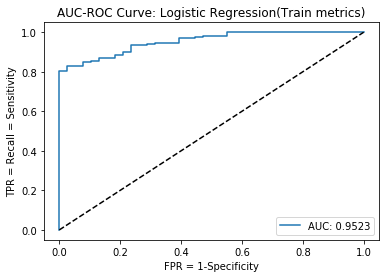

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8544 |
|      F1-score     | 0.9123 |
|     Precision     | 0.9176 |
|       Recall      | 0.907  |
|    Specificity    | 0.5882 |
|        MCC        | 0.4841 |
|    AUROC value    | 0.7873 |
+-------------------+--------+


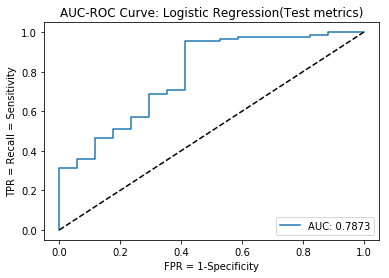

--------------------------------------------------------------





In [8]:
logistic_GA_model, logistic_GA_metric_list_train, logistic_GA_metric_list_test  = model_logistic_regression(X_train_GA, X_test_GA,y_train, y_test)

### SVM

SVM(kernel=RBF) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9114 |
|      F1-score     | 0.9499 |
|     Precision     | 0.9045 |
|       Recall      |  1.0   |
|    Specificity    | 0.4474 |
|        MCC        | 0.6361 |
|    AUROC value    | 0.9856 |
+-------------------+--------+


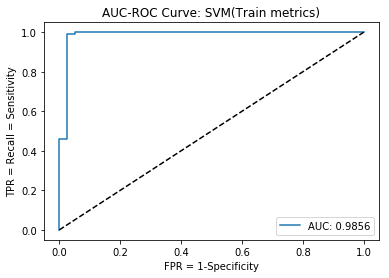

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8835 |
|      F1-score     | 0.9348 |
|     Precision     | 0.8776 |
|       Recall      |  1.0   |
|    Specificity    | 0.2941 |
|        MCC        | 0.508  |
|    AUROC value    | 0.7811 |
+-------------------+--------+


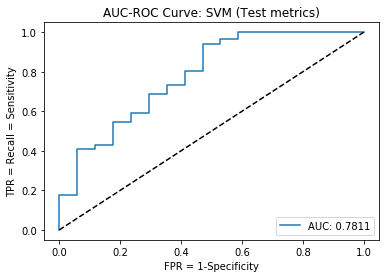

--------------------------------------------------------------





In [9]:
rbfsvm_GA_model, rbfsvm_GA_metric_list_train, rbfsvm_GA_metric_list_test = model_rbfsvm(X_train_GA, X_test_GA,y_train, y_test)

### Decision Tree

DecisionTree classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


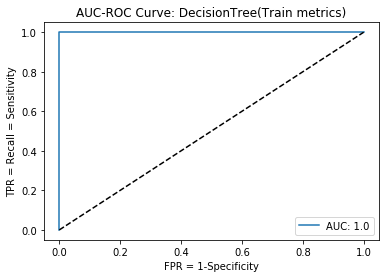

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8544 |
|      F1-score     | 0.9133 |
|     Precision     | 0.908  |
|       Recall      | 0.9186 |
|    Specificity    | 0.5294 |
|        MCC        | 0.4591 |
|    AUROC value    | 0.724  |
+-------------------+--------+


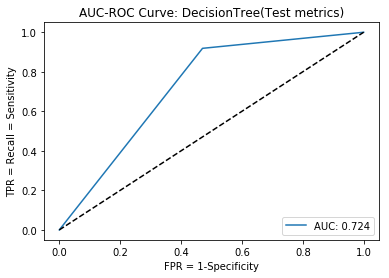

--------------------------------------------------------------





In [10]:
# dtree_GA_model_1, dtree_GA_metric_list_train_1, dtree_GA_metric_list_test_1 = model_dTree_2(X_train_GA, X_test_GA,y_train, y_test)

# dtree_GA_model_2, dtree_GA_metric_list_train_2, dtree_GA_metric_list_test_2 = model_dTree_2(X_train_GA, X_test_GA,y_train, y_test)

dtree_GA_model_3, dtree_GA_metric_list_train_3, dtree_GA_metric_list_test_3 = model_dTree_3(X_train_GA, X_test_GA,y_train, y_test)

### MLP

MLP classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


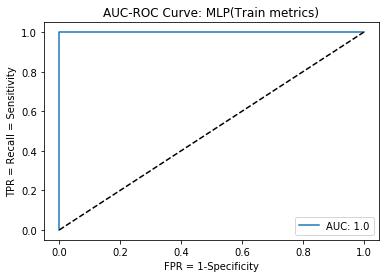

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8544 |
|      F1-score     | 0.9133 |
|     Precision     | 0.908  |
|       Recall      | 0.9186 |
|    Specificity    | 0.5294 |
|        MCC        | 0.4591 |
|    AUROC value    | 0.8311 |
+-------------------+--------+


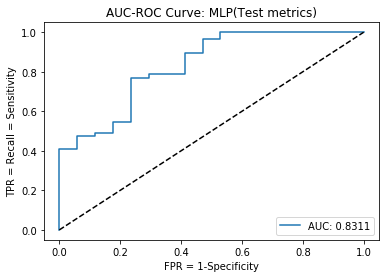

--------------------------------------------------------------





In [11]:
layer1, layer2 = 151,151
mlp_GA_model, mlp_GA_metric_list_train, mlp_GA_metric_list_test = model_mlp(X_train_GA, X_test_GA, y_train, y_test, layer1, layer2)

### Random Forest

Random Forest classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


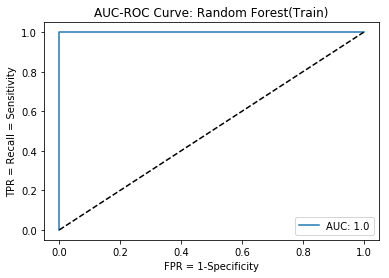

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9126 |
|      F1-score     | 0.9497 |
|     Precision     | 0.914  |
|       Recall      | 0.9884 |
|    Specificity    | 0.5294 |
|        MCC        | 0.6492 |
|    AUROC value    | 0.788  |
+-------------------+--------+


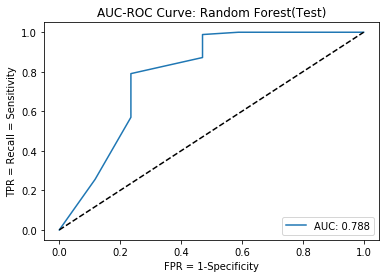

--------------------------------------------------------------





In [12]:
# rf_GA_model_1, rf_GA_metric_list_train_1, rf_GA_metric_list_test_1 = model_random_forest_1(X_train_GA, X_test_GA,y_train, y_test)

# rf_GA_model_2, rf_GA_metric_list_train_2, rf_GA_metric_list_test_2 = model_random_forest_2(X_train_GA, X_test_GA,y_train, y_test)

rf_GA_model_3, rf_GA_metric_list_train_3, rf_GA_metric_list_test_3 = model_random_forest_3(X_train_GA, X_test_GA,y_train, y_test)

### ====================================================================

# X+GADel

In [13]:
X_train_GADel, X_test_GADel = deepcopy(complete_X_train),deepcopy(complete_X_test)

X_train_GADel = pd.concat([X_train_GADel,excluded_features_train['GADel']],axis=1)
X_test_GADel  = pd.concat([X_test_GADel,excluded_features_test['GADel']],axis=1)

X_train_GADel, X_test_GADel = X_train_GADel.values, X_test_GADel.values

#### Normalizing

In [14]:
X_train_GADel, X_test_GADel = scale(X_train_GADel), scale(X_test_GADel)

### Logistic regression

Logistic Regression
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


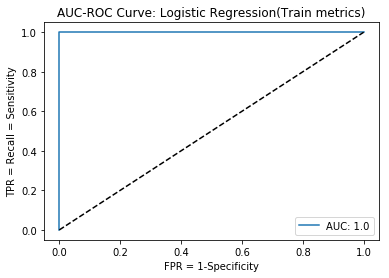

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9903 |
|      F1-score     | 0.9942 |
|     Precision     |  1.0   |
|       Recall      | 0.9884 |
|    Specificity    |  1.0   |
|        MCC        | 0.9662 |
|    AUROC value    | 0.9979 |
+-------------------+--------+


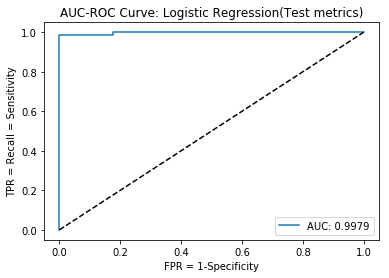

--------------------------------------------------------------





In [15]:
logistic_GADel_model, logistic_GADel_metric_list_train, logistic_GADel_metric_list_test = model_logistic_regression(X_train_GADel, X_test_GADel,y_train, y_test)

### SVM

SVM(kernel=RBF) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9873 |
|      F1-score     | 0.9925 |
|     Precision     | 0.9851 |
|       Recall      |  1.0   |
|    Specificity    | 0.9211 |
|        MCC        | 0.9526 |
|    AUROC value    |  1.0   |
+-------------------+--------+


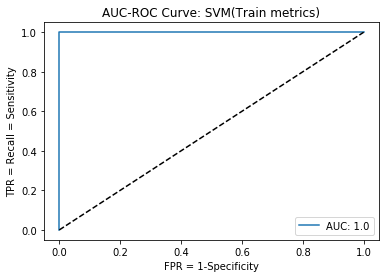

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9417 |
|      F1-score     | 0.9663 |
|     Precision     | 0.9348 |
|       Recall      |  1.0   |
|    Specificity    | 0.6471 |
|        MCC        | 0.7777 |
|    AUROC value    | 0.9932 |
+-------------------+--------+


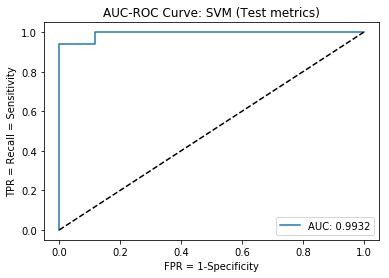

--------------------------------------------------------------





In [16]:
rbfsvm_GADel_model, rbfsvm_GADel_metric_list_train, rbfsvm_GADel_metric_list_test = model_rbfsvm(X_train_GADel, X_test_GADel,y_train, y_test)

### Decision Tree

DecisionTree classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


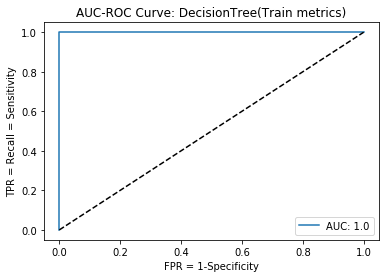

--------------------------------------------------------------



+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


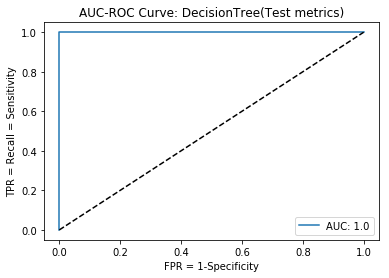

--------------------------------------------------------------





In [17]:
# dtree_GADel_model_1, dtree_GADel_metric_list_train_1, dtree_GADel_metric_list_test_1 = model_dTree_1(X_train_GADel, X_test_GADel,y_train, y_test)

# dtree_GADel_model_2, dtree_GADel_metric_list_train_2, dtree_GADel_metric_list_test_2 = model_dTree_2(X_train_GADel, X_test_GADel,y_train, y_test)

dtree_GADel_model_3, dtree_GADel_metric_list_train_3, dtree_GADel_metric_list_test_3 = model_dTree_3(X_train_GADel, X_test_GADel,y_train, y_test)

### MLP

MLP classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


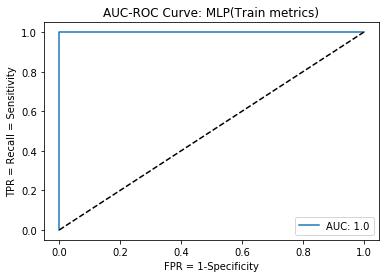

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.932  |
|      F1-score     | 0.9595 |
|     Precision     | 0.954  |
|       Recall      | 0.9651 |
|    Specificity    | 0.7647 |
|        MCC        | 0.7479 |
|    AUROC value    | 0.9713 |
+-------------------+--------+


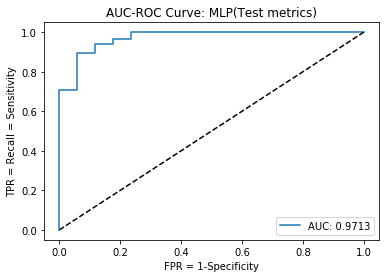

--------------------------------------------------------------





In [18]:
layer1, layer2 = 151, 151
mlp_GADel_model, mlp_GADel_metric_list_train, mlp_GADel_metric_list_test = model_mlp(X_train_GADel, X_test_GADel,y_train, y_test, layer1, layer2)

### Random Forest

Random Forest classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


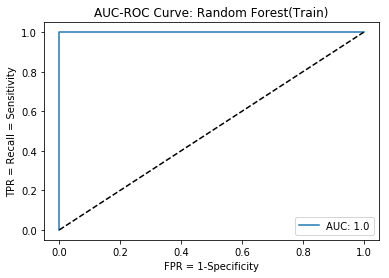

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9709 |
|      F1-score     | 0.9829 |
|     Precision     | 0.9663 |
|       Recall      |  1.0   |
|    Specificity    | 0.8235 |
|        MCC        | 0.8921 |
|    AUROC value    | 0.9932 |
+-------------------+--------+


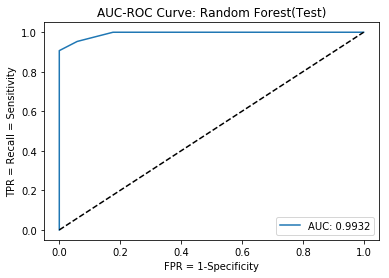

--------------------------------------------------------------





In [19]:
# rf_GADel_model_1, rf_GADel_metric_list_train_1, rf_GADel_metric_list_test_1 = model_random_forest_1(X_train_GADel, X_test_GADel,y_train, y_test)

# rf_GADel_model_2, rf_GADel_metric_list_train_2, rf_GADel_metric_list_test_2 = model_random_forest_2(X_train_GADel, X_test_GADel,y_train, y_test)

rf_GADel_model_3, rf_GADel_metric_list_train_3, rf_GADel_metric_list_test_3 = model_random_forest_3(X_train_GADel, X_test_GADel,y_train, y_test)

### ====================================================================

# X+TTD

In [20]:
X_train_TTD, X_test_TTD = deepcopy(complete_X_train),deepcopy(complete_X_test)

X_train_TTD = pd.concat([X_train_TTD,excluded_features_train['TTD']],axis=1)
X_test_TTD  = pd.concat([X_test_TTD,excluded_features_test['TTD']],axis=1)

#### Normalizing

In [21]:
X_train_TTD, X_test_TTD = scale(X_train_TTD), scale(X_test_TTD)

### Logistic regression

Logistic Regression
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9367 |
|      F1-score     | 0.9633 |
|     Precision     | 0.9381 |
|       Recall      | 0.9899 |
|    Specificity    | 0.6579 |
|        MCC        | 0.7482 |
|    AUROC value    | 0.9648 |
+-------------------+--------+


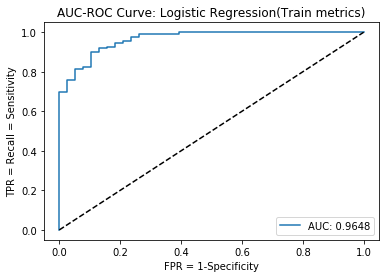

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.835  |
|      F1-score     | 0.8994 |
|     Precision     | 0.9157 |
|       Recall      | 0.8837 |
|    Specificity    | 0.5882 |
|        MCC        | 0.4429 |
|    AUROC value    | 0.8365 |
+-------------------+--------+


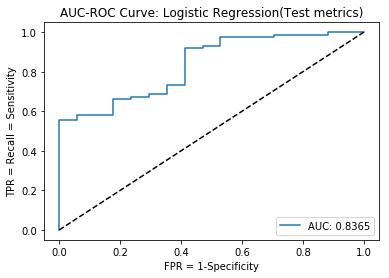

--------------------------------------------------------------





In [22]:
logistic_TTD_model, logistic_TTD_metric_list_train, logistic_TTD_metric_list_test = model_logistic_regression(X_train_TTD, X_test_TTD,y_train, y_test)

### SVM

SVM(kernel=RBF) classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


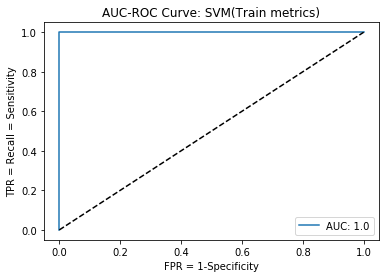

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8252 |
|      F1-score     | 0.9043 |
|     Precision     | 0.8333 |
|       Recall      | 0.9884 |
|    Specificity    |  0.0   |
|        MCC        | -0.044 |
|    AUROC value    | 0.7544 |
+-------------------+--------+


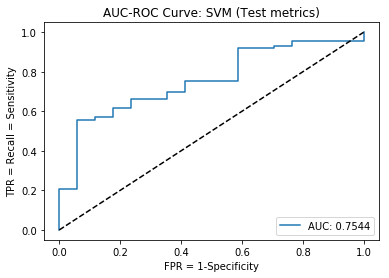

--------------------------------------------------------------





In [23]:
rbfsvm_TTD_model, rbfsvm_TTD_metric_list_train, rbfsvm_TTD_metric_list_test = model_rbfsvm(X_train_TTD, X_test_TTD,y_train, y_test)

### Decision Tree

DecisionTree classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


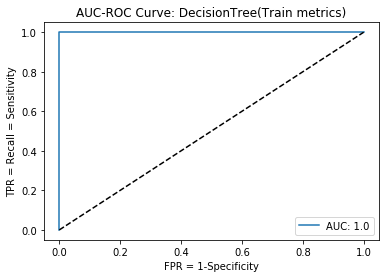

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.7961 |
|      F1-score     |  0.88  |
|     Precision     | 0.8652 |
|       Recall      | 0.8953 |
|    Specificity    | 0.2941 |
|        MCC        | 0.2052 |
|    AUROC value    | 0.5947 |
+-------------------+--------+


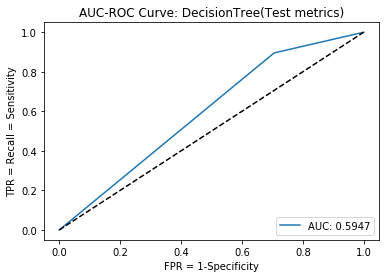

--------------------------------------------------------------





In [24]:
# dtree_TTD_model_1, dtree_TTD_metric_list_train_1, dtree_TTD_metric_list_test_1 = model_dTree_1(X_train_TTD, X_test_TTD,y_train, y_test)

# dtree_TTD_model_2, dtree_TTD_metric_list_train_2, dtree_TTD_metric_list_test_2 = model_dTree_2(X_train_TTD, X_test_TTD,y_train, y_test)

dtree_TTD_model_3, dtree_TTD_metric_list_train_3, dtree_TTD_metric_list_test_3 = model_dTree_3(X_train_TTD, X_test_TTD,y_train, y_test)

### MLP

MLP classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


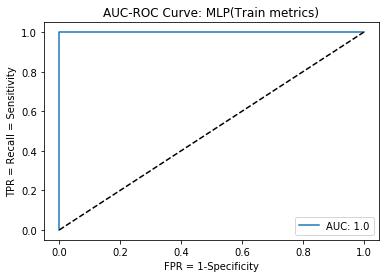

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8544 |
|      F1-score     | 0.9133 |
|     Precision     | 0.908  |
|       Recall      | 0.9186 |
|    Specificity    | 0.5294 |
|        MCC        | 0.4591 |
|    AUROC value    | 0.8434 |
+-------------------+--------+


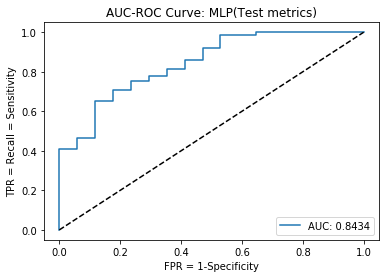

--------------------------------------------------------------





In [25]:
layer1, layer2 = 151, 151
mlp_TTD_model, mlp_TTD_metric_list_train, mlp_TTD_metric_list_test = model_mlp(X_train_TTD, X_test_TTD,y_train, y_test, layer1, layer2)

### Random Forest

Random Forest classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


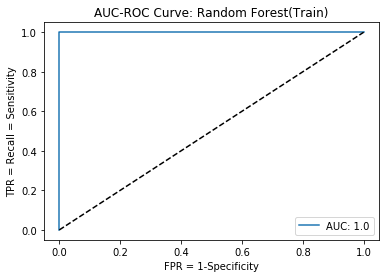

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8544 |
|      F1-score     | 0.9162 |
|     Precision     | 0.8817 |
|       Recall      | 0.9535 |
|    Specificity    | 0.3529 |
|        MCC        | 0.3842 |
|    AUROC value    | 0.7678 |
+-------------------+--------+


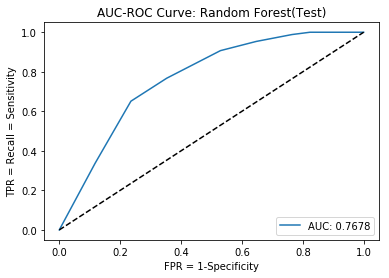

--------------------------------------------------------------





In [26]:
# rf_TTD_model_1, rf_TTD_metric_list_train_1, rf_TTD_metric_list_test_1 = model_random_forest_1(X_train_TTD, X_test_TTD,y_train, y_test)

# rf_TTD_model_2, rf_TTD_metric_list_train_2, rf_TTD_metric_list_test_2 = model_random_forest_2(X_train_TTD, X_test_TTD,y_train, y_test)

rf_TTD_model_3, rf_TTD_metric_list_train_3, rf_TTD_metric_list_test_3 = model_random_forest_3(X_train_TTD, X_test_TTD,y_train, y_test)

### ====================================================================

# X+GA+GADel

In [27]:
X_train_GA_GADel, X_test_GA_GADel = deepcopy(complete_X_train),deepcopy(complete_X_test)

X_train_GA_GADel = pd.concat([X_train_GA_GADel,excluded_features_train[['GA','GADel']]],axis=1)
X_test_GA_GADel  = pd.concat([X_test_GA_GADel,excluded_features_test[['GA','GADel']]],axis=1)

X_train_GA_GADel, X_test_GA_GADel = X_train_GA_GADel.values, X_test_GA_GADel.values

#### Normalizing

In [28]:
X_train_GA_GADel, X_test_GA_GADel = scale(X_train_GA_GADel), scale(X_test_GA_GADel)

### Logistic regression

Logistic Regression
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


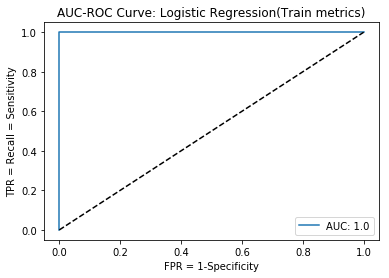

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9806 |
|      F1-score     | 0.9884 |
|     Precision     | 0.9884 |
|       Recall      | 0.9884 |
|    Specificity    | 0.9412 |
|        MCC        | 0.9295 |
|    AUROC value    | 0.9966 |
+-------------------+--------+


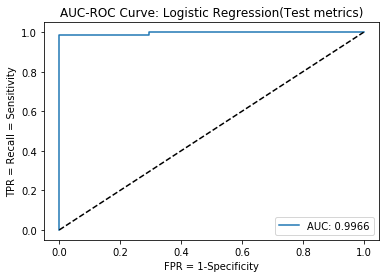

--------------------------------------------------------------





In [29]:
logistic_GA_GADel_model, logistic_GA_GADel_metric_list_train, logistic_GA_GADel_metric_list_test = model_logistic_regression(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

### SVM

SVM(kernel=RBF) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9873 |
|      F1-score     | 0.9925 |
|     Precision     | 0.9851 |
|       Recall      |  1.0   |
|    Specificity    | 0.9211 |
|        MCC        | 0.9526 |
|    AUROC value    |  1.0   |
+-------------------+--------+


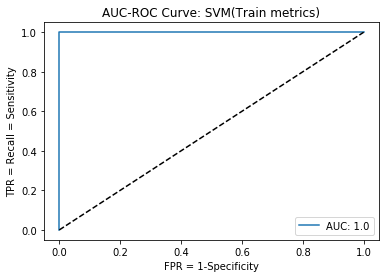

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9417 |
|      F1-score     | 0.9663 |
|     Precision     | 0.9348 |
|       Recall      |  1.0   |
|    Specificity    | 0.6471 |
|        MCC        | 0.7777 |
|    AUROC value    | 0.9925 |
+-------------------+--------+


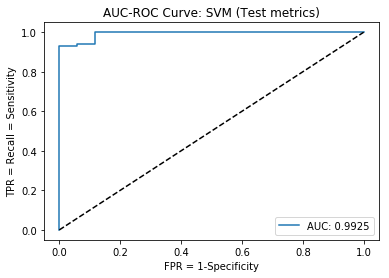

--------------------------------------------------------------





In [30]:
rbfsvm_GA_GADel_model, rbfsvm_GA_GADel_metric_list_train, rbfsvm_GA_GADel_metric_list_test = model_rbfsvm(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

### Decision Tree

DecisionTree classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


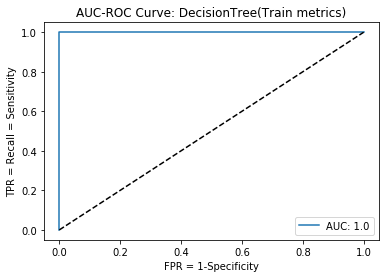

--------------------------------------------------------------



+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


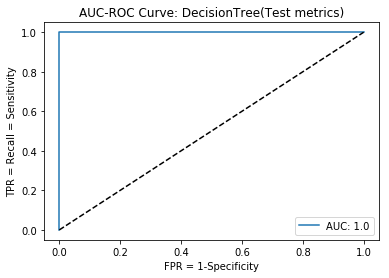

--------------------------------------------------------------





In [31]:
# dtree_GA_GADel_model_1, dtree_GA_GADel_metric_list_train_1, dtree_GA_GADel_metric_list_test_1 = model_dTree_1(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# dtree_GA_GADel_model_2, dtree_GA_GADel_metric_list_train_2, dtree_GA_GADel_metric_list_test_2 = model_dTree_2(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

dtree_GA_GADel_model_3, dtree_GA_GADel_metric_list_train_3, dtree_GA_GADel_metric_list_test_3 = model_dTree_3(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

### MLP

MLP classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


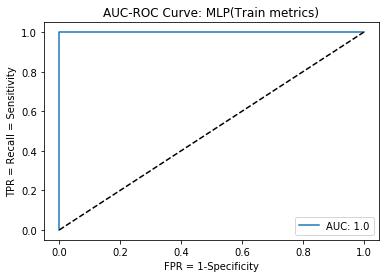

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9515 |
|      F1-score     | 0.9714 |
|     Precision     | 0.9551 |
|       Recall      | 0.9884 |
|    Specificity    | 0.7647 |
|        MCC        | 0.8157 |
|    AUROC value    | 0.9897 |
+-------------------+--------+


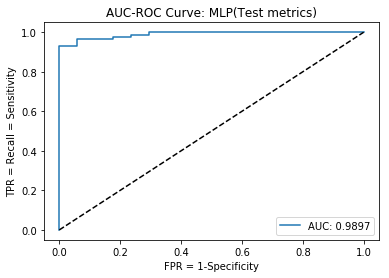

--------------------------------------------------------------





In [32]:
layer1, layer2 = 152, 152
mlp_GA_GADel_model, mlp_GA_GADel_metric_list_train, mlp_GA_GADel_metric_list_test = model_mlp(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test, layer1, layer2)

### Random Forest

Random Forest classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9916 |
|      F1-score     | 0.9949 |
|     Precision     |  1.0   |
|       Recall      | 0.9899 |
|    Specificity    |  1.0   |
|        MCC        | 0.9698 |
|    AUROC value    | 0.9994 |
+-------------------+--------+


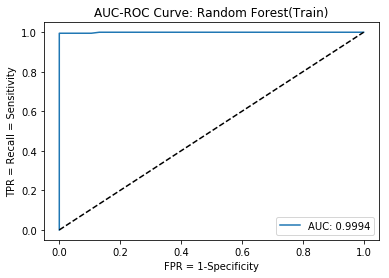

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9223 |
|      F1-score     | 0.9551 |
|     Precision     | 0.9239 |
|       Recall      | 0.9884 |
|    Specificity    | 0.5882 |
|        MCC        | 0.693  |
|    AUROC value    | 0.9586 |
+-------------------+--------+


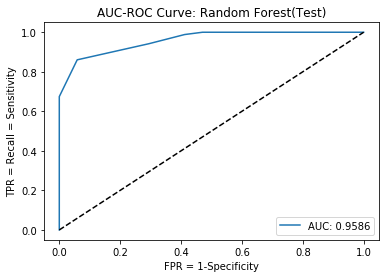

--------------------------------------------------------------





In [33]:
# rf_GA_GADel_model_1, rf_GA_GADel_metric_list_train_1, rf_GA_GADel_metric_list_test_1 = model_random_forest_1(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# rf_GA_GADel_model_2, rf_GA_GADel_metric_list_train_2, rf_GA_GADel_metric_list_test_2 = model_random_forest_2(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

rf_GA_GADel_model_3, rf_GA_GADel_metric_list_train_3, rf_GA_GADel_metric_list_test_3 = model_random_forest_3(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

### ====================================================================

# X+GA+TTD

In [34]:
X_train_GA_TTD, X_test_GA_TTD = deepcopy(complete_X_train),deepcopy(complete_X_test)

X_train_GA_TTD = pd.concat([X_train_GA_TTD,excluded_features_train[['GA','TTD']]],axis=1)
X_test_GA_TTD  = pd.concat([X_test_GA_TTD,excluded_features_test[['GA','TTD']]],axis=1)

X_train_GA_TTD, X_test_GA_TTD = X_train_GA_TTD.values, X_test_GA_TTD.values

#### Normalizing

In [35]:
X_train_GA_TTD, X_test_GA_TTD = scale(X_train_GA_TTD), scale(X_test_GA_TTD)

### Logistic regression

Logistic Regression
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


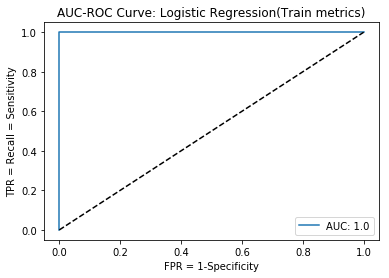

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8447 |
|      F1-score     | 0.9059 |
|     Precision     | 0.9167 |
|       Recall      | 0.8953 |
|    Specificity    | 0.5882 |
|        MCC        | 0.4628 |
|    AUROC value    | 0.9289 |
+-------------------+--------+


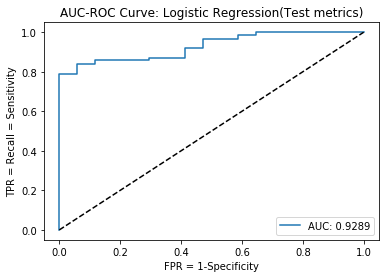

--------------------------------------------------------------





In [36]:
logistic_GA_TTD_model, logistic_GA_TTD_metric_list_train, logistic_GA_TTD_metric_list_test = model_logistic_regression(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

### SVM

SVM(kernel=RBF) classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


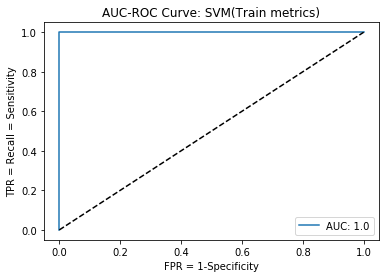

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8252 |
|      F1-score     | 0.9043 |
|     Precision     | 0.8333 |
|       Recall      | 0.9884 |
|    Specificity    |  0.0   |
|        MCC        | -0.044 |
|    AUROC value    | 0.7832 |
+-------------------+--------+


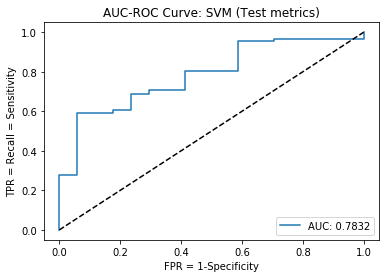

--------------------------------------------------------------





In [37]:
rbfsvm_GA_TTD_model, rbfsvm_GA_TTD_metric_list_train, rbfsvm_GA_TTD_metric_list_test = model_rbfsvm(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

### Decision Tree

DecisionTree classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


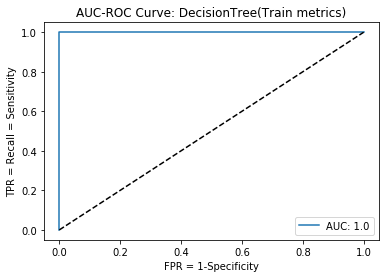

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.767  |
|      F1-score     | 0.8588 |
|     Precision     | 0.869  |
|       Recall      | 0.8488 |
|    Specificity    | 0.3529 |
|        MCC        | 0.1931 |
|    AUROC value    | 0.6009 |
+-------------------+--------+


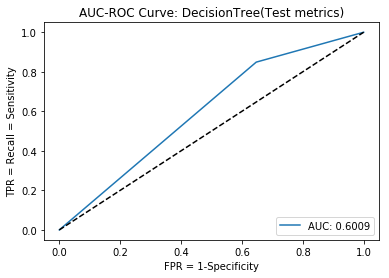

--------------------------------------------------------------





In [38]:
# dtree_GA_TTD_model_1, dtree_GA_TTD_metric_list_train_1, dtree_GA_TTD_metric_list_test_1 = model_dTree_1(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# dtree_GA_TTD_model_2, dtree_GA_TTD_metric_list_train_2, dtree_GA_TTD_metric_list_test_2 = model_dTree_2(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

dtree_GA_TTD_model_3, dtree_GA_TTD_metric_list_train_3, dtree_GA_TTD_metric_list_test_3 = model_dTree_3(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

### MLP

MLP classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


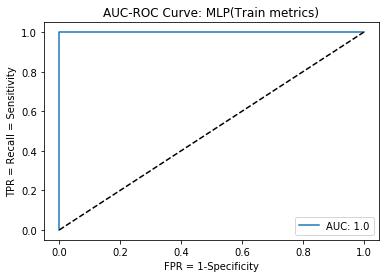

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8544 |
|      F1-score     | 0.9133 |
|     Precision     | 0.908  |
|       Recall      | 0.9186 |
|    Specificity    | 0.5294 |
|        MCC        | 0.4591 |
|    AUROC value    | 0.8358 |
+-------------------+--------+


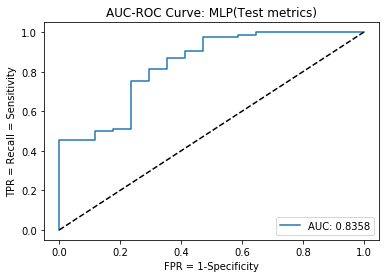

--------------------------------------------------------------





In [39]:
layer1, layer2 = 152, 152
mlp_GA_TTD_model, mlp_GA_TTD_metric_list_train, mlp_GA_TTD_metric_list_test = model_mlp(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test, layer1, layer2)

### Random Forest

Random Forest classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9916 |
|      F1-score     | 0.995  |
|     Precision     |  0.99  |
|       Recall      |  1.0   |
|    Specificity    | 0.9474 |
|        MCC        | 0.9685 |
|    AUROC value    | 0.9999 |
+-------------------+--------+


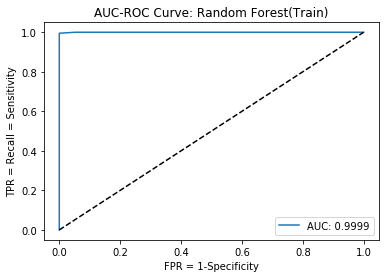

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8641 |
|      F1-score     | 0.9213 |
|     Precision     | 0.8913 |
|       Recall      | 0.9535 |
|    Specificity    | 0.4118 |
|        MCC        | 0.439  |
|    AUROC value    | 0.7373 |
+-------------------+--------+


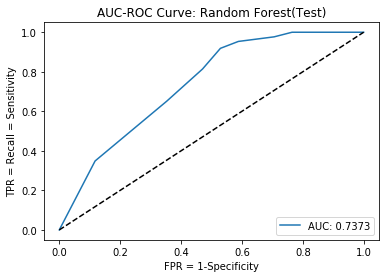

--------------------------------------------------------------





In [40]:
# rf_GA_TTD_model_1, rf_GA_TTD_metric_list_train_1, rf_GA_TTD_metric_list_test_1 = model_random_forest_1(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# rf_GA_TTD_model_2, rf_GA_TTD_metric_list_train_2, rf_GA_TTD_metric_list_test_2 = model_random_forest_2(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

rf_GA_TTD_model_3, rf_GA_TTD_metric_list_train_3, rf_GA_TTD_metric_list_test_3 = model_random_forest_3(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

### ====================================================================

# X+GADel+TTD

In [41]:
X_train_GADel_TTD, X_test_GADel_TTD = deepcopy(complete_X_train),deepcopy(complete_X_test)

X_train_GADel_TTD = pd.concat([X_train_GADel_TTD,excluded_features_train[['GADel','TTD']]],axis=1)
X_test_GADel_TTD = pd.concat([X_test_GADel_TTD,excluded_features_test[['GADel','TTD']]],axis=1)

X_train_GADel_TTD, X_test_GADel_TTD = X_train_GADel_TTD.values, X_test_GADel_TTD.values

#### Normalizing

In [42]:
X_train_GADel_TTD, X_test_GADel_TTD = scale(X_train_GADel_TTD), scale(X_test_GADel_TTD)

### Logistic regression

Logistic Regression
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


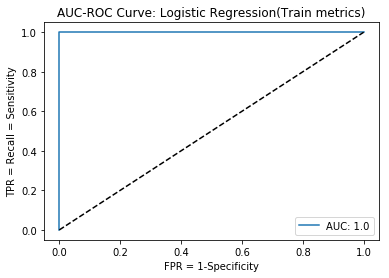

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9806 |
|      F1-score     | 0.9882 |
|     Precision     |  1.0   |
|       Recall      | 0.9767 |
|    Specificity    |  1.0   |
|        MCC        | 0.9348 |
|    AUROC value    | 0.9979 |
+-------------------+--------+


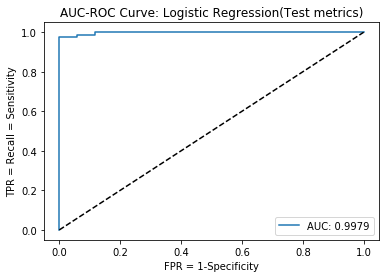

--------------------------------------------------------------





In [43]:
logistic_GADel_TTD_model, logistic_GADel_TTD_metric_list_train, logistic_GADel_TTD_metric_list_test = model_logistic_regression(X_train_GADel_TTD, X_test_GADel_TTD,y_train, y_test)

### SVM

SVM(kernel=RBF) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9916 |
|      F1-score     | 0.995  |
|     Precision     |  0.99  |
|       Recall      |  1.0   |
|    Specificity    | 0.9474 |
|        MCC        | 0.9685 |
|    AUROC value    |  1.0   |
+-------------------+--------+


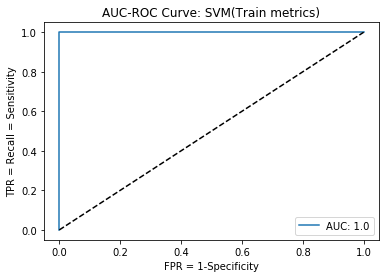

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9417 |
|      F1-score     | 0.9663 |
|     Precision     | 0.9348 |
|       Recall      |  1.0   |
|    Specificity    | 0.6471 |
|        MCC        | 0.7777 |
|    AUROC value    | 0.9877 |
+-------------------+--------+


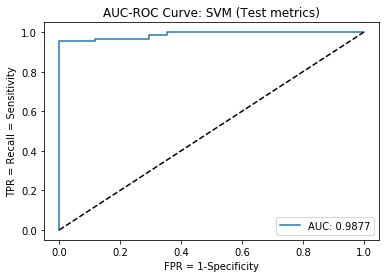

--------------------------------------------------------------





In [44]:
rbfsvm_GADel_TTD_model, rbfsvm_GADel_TTD_metric_list_train, rbfsvm_GADel_TTD_metric_list_test = model_rbfsvm(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

### Decision Tree

DecisionTree classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


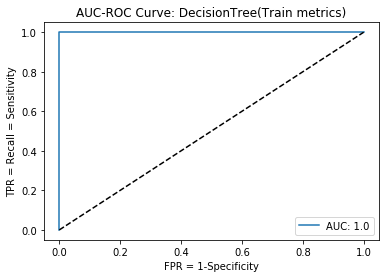

--------------------------------------------------------------



+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


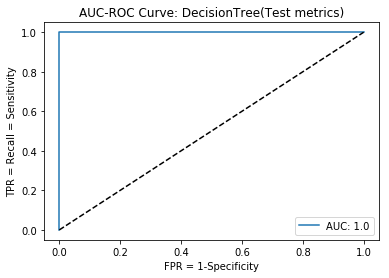

--------------------------------------------------------------





In [45]:
# dtree_GADel_TTD_model_1, dtree_GADel_TTD_metric_list_train_1, dtree_GADel_TTD_metric_list_test_1 = model_dTree_1(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

# dtree_GADel_TTD_model_2, dtree_GADel_TTD_metric_list_train_2, dtree_GADel_TTD_metric_list_test_2 = model_dTree_2(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

dtree_GADel_TTD_model_3, dtree_GADel_TTD_metric_list_train_3, dtree_GADel_TTD_metric_list_test_3 = model_dTree_3(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

### MLP

MLP classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


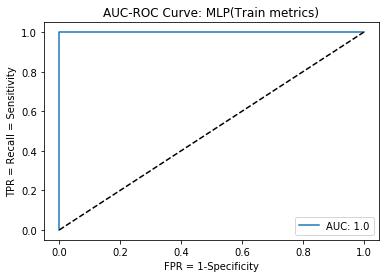

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.932  |
|      F1-score     | 0.9591 |
|     Precision     | 0.9647 |
|       Recall      | 0.9535 |
|    Specificity    | 0.8235 |
|        MCC        | 0.7596 |
|    AUROC value    | 0.9788 |
+-------------------+--------+


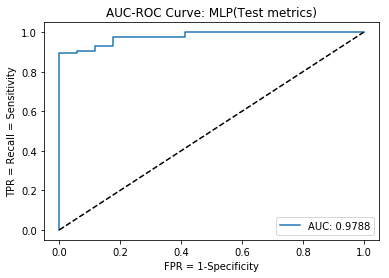

--------------------------------------------------------------





In [46]:
layer1, layer2 = 152, 152
mlp_GADel_TTD_model, mlp_GADel_TTD_metric_list_train, mlp_GADel_TTD_metric_list_test = model_mlp(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test, layer1, layer2)

### Random Forest

Random Forest classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


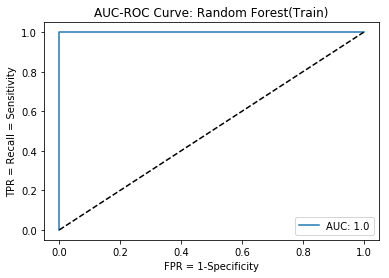

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8738 |
|      F1-score     | 0.9282 |
|     Precision     | 0.8842 |
|       Recall      | 0.9767 |
|    Specificity    | 0.3529 |
|        MCC        | 0.4573 |
|    AUROC value    | 0.8249 |
+-------------------+--------+


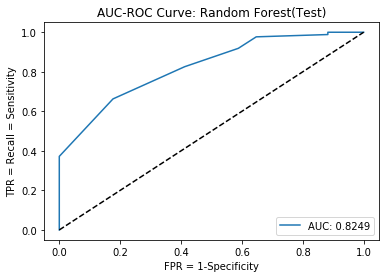

--------------------------------------------------------------





In [47]:
# rf_GADel_TTD_model_1, rf_GADel_TTD_metric_list_train_1, rf_GADel_TTD_metric_list_test_1 = model_random_forest_1(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

# rf_GADel_TTD_model_2, rf_GADel_TTD_metric_list_train_2, rf_GADel_TTD_metric_list_test_2 = model_random_forest_2(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

rf_GADel_TTD_model_3, rf_GADel_TTD_metric_list_train_3, rf_GADel_TTD_metric_list_test_3 = model_random_forest_3(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

### ====================================================================

# X+all

In [48]:
X_train_all, X_test_all = deepcopy(complete_X_train),deepcopy(complete_X_test)

X_train_all = pd.concat([X_train_all,excluded_features_train[['GA','GADel','TTD']]],axis=1)
X_test_all = pd.concat([X_test_all,excluded_features_test[['GA','GADel','TTD']]],axis=1)

X_train_all, X_test_all = X_train_all.values, X_test_all.values

#### Normalizing

In [49]:
X_train_all, X_test_all = scale(X_train_all), scale(X_test_all)

### Logistic regression

Logistic Regression
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


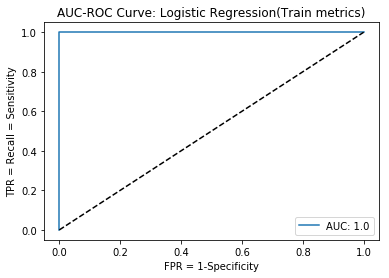

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9903 |
|      F1-score     | 0.9942 |
|     Precision     |  1.0   |
|       Recall      | 0.9884 |
|    Specificity    |  1.0   |
|        MCC        | 0.9662 |
|    AUROC value    | 0.9986 |
+-------------------+--------+


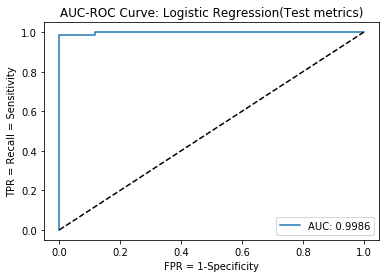

--------------------------------------------------------------





In [50]:
logistic_all_model, logistic_all_metric_list_train, logistic_all_metric_list_test = model_logistic_regression(X_train_all, X_test_all,y_train, y_test)

### SVM

SVM(kernel=RBF) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9916 |
|      F1-score     | 0.995  |
|     Precision     |  0.99  |
|       Recall      |  1.0   |
|    Specificity    | 0.9474 |
|        MCC        | 0.9685 |
|    AUROC value    |  1.0   |
+-------------------+--------+


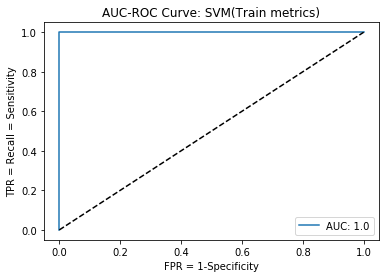

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9417 |
|      F1-score     | 0.9663 |
|     Precision     | 0.9348 |
|       Recall      |  1.0   |
|    Specificity    | 0.6471 |
|        MCC        | 0.7777 |
|    AUROC value    | 0.9925 |
+-------------------+--------+


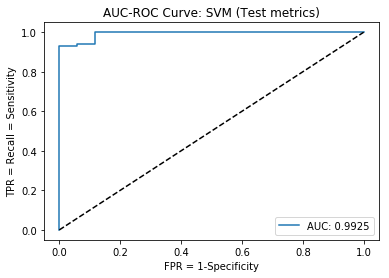

--------------------------------------------------------------





In [51]:
rbfsvm_all_model, rbfsvm_all_metric_list_train, rbfsvm_all_metric_list_test = model_rbfsvm(X_train_all, X_test_all,y_train, y_test)

### Decision Tree

DecisionTree classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


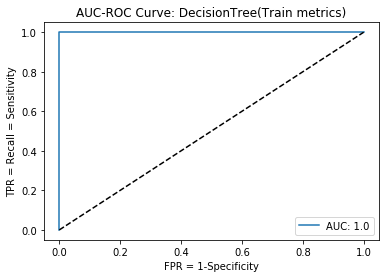

--------------------------------------------------------------



+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


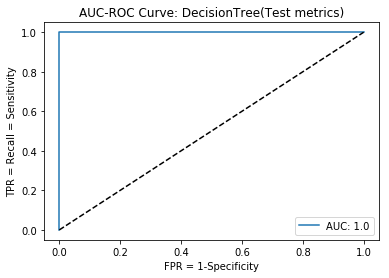

--------------------------------------------------------------





In [52]:
# dtree_all_model_1, dtree_all_metric_list_train_1, dtree_all_metric_list_train_1 = model_dTree_1(X_train_all, X_test_all,y_train, y_test)

# dtree_all_model_2, dtree_all_metric_list_train_2, dtree_all_metric_list_train_2 = model_dTree_2(X_train_all, X_test_all,y_train, y_test)

dtree_all_model_3, dtree_all_metric_list_train_3, dtree_all_metric_list_test_3 = model_dTree_3(X_train_all, X_test_all,y_train, y_test)

### MLP

MLP classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


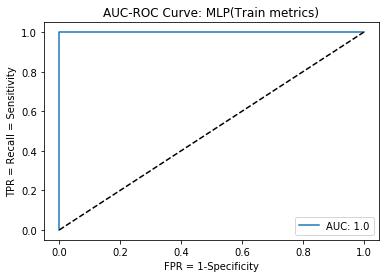

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9126 |
|      F1-score     | 0.9474 |
|     Precision     | 0.9529 |
|       Recall      | 0.9419 |
|    Specificity    | 0.7647 |
|        MCC        | 0.6907 |
|    AUROC value    | 0.9774 |
+-------------------+--------+


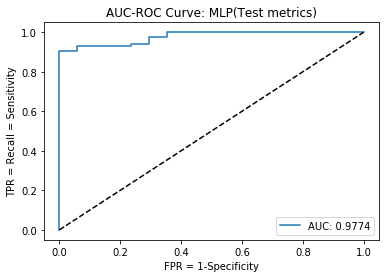

--------------------------------------------------------------





In [53]:
layer1, layer2 = 153, 153
mlp_all_model, mlp_all_metric_list_train, mlp_all_metric_list_test = model_mlp(X_train_all, X_test_all,y_train, y_test, layer1, layer2)

### Random Forest

Random Forest classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


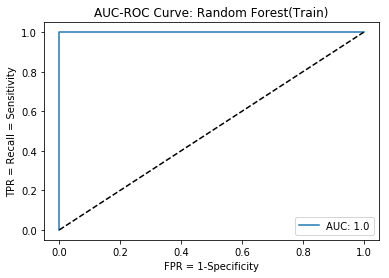

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9709 |
|      F1-score     | 0.9829 |
|     Precision     | 0.9663 |
|       Recall      |  1.0   |
|    Specificity    | 0.8235 |
|        MCC        | 0.8921 |
|    AUROC value    | 0.999  |
+-------------------+--------+


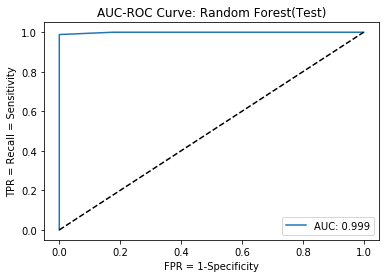

--------------------------------------------------------------





In [54]:
# rf_all_model_1, rf_all_metric_list_train_1, rf_all_metric_list_test_1 = model_random_forest_1(X_train_all, X_test_all,y_train, y_test)
# rf_all_model_2, rf_all_metric_list_train_2, rf_all_metric_list_test_2 = model_random_forest_2(X_train_all, X_test_all,y_train, y_test)

rf_all_model_3, rf_all_metric_list_train_3, rf_all_metric_list_test_3 = model_random_forest_3(X_train_all, X_test_all,y_train, y_test)

### ====================================================================

### Writting Output

#### excluded

In [55]:
# results_excluded_logistic_train = pd.DataFrame(logistic_excluded_metric_list_train,columns = ['Metric', 'Score'])
# results_excluded_logistic_test  = pd.DataFrame(logistic_excluded_metric_list_test,columns = ['Metric', 'Score'])

# results_excluded_svm_train = pd.DataFrame(rbfsvm_excluded_metric_list_train,columns = ['Metric', 'Score'])
# results_excluded_svm_test  = pd.DataFrame(rbfsvm_excluded_metric_list_test,columns = ['Metric', 'Score'])

# results_excluded_dTree_train = pd.DataFrame(dtree_excluded_metric_list_train_3,columns = ['Metric', 'Score'])
# results_excluded_dTree_test  = pd.DataFrame(dtree_excluded_metric_list_test_3,columns = ['Metric', 'Score'])

# results_excluded_mlp_train = pd.DataFrame(mlp_excluded_metric_list_train,columns = ['Metric', 'Score'])
# results_excluded_mlp_test  = pd.DataFrame(mlp_excluded_metric_list_test,columns = ['Metric', 'Score'])

# results_excluded_rf_train = pd.DataFrame(rf_excluded_metric_list_train_3,columns = ['Metric', 'Score'])
# results_excluded_rf_test  = pd.DataFrame(rf_excluded_metric_list_test_3,columns = ['Metric', 'Score'])

# logistic_excluded_results = pd.concat([results_excluded_logistic_train,results_excluded_logistic_test],keys=['Log. Reg. with feature selection: Train','Log. Reg. with feature selection: Test'], axis=1)
# svm_excluded_results = pd.concat([results_excluded_svm_train,results_excluded_svm_test],keys=['SVM with feature selection: Train','SVM with feature selection: Test'], axis=1)
# dtree_excluded_results = pd.concat([results_excluded_dTree_train,results_excluded_dTree_test],keys=['DTree with feature selection: Train','DTree with feature selection: Test'], axis=1)
# mlp_excluded_results = pd.concat([results_excluded_mlp_train,results_excluded_mlp_test],keys=['MLP with feature selection: Train','MLP with feature selection: Test'], axis=1)
# rf_excluded_results = pd.concat([results_excluded_rf_train,results_excluded_rf_test],keys=['RF with feature selection: Train','RF with feature selection: Test'], axis=1)

# # clf_all = pd.concat([logistic_excluded_results,svm_excluded_results,dtree_excluded_results,mlp_excluded_results,rf_excluded_results],axis=1)
# # clf_all.to_csv('MT18117_SUBHANI_SHAIK_q4_analysis.csv')

# MT18117_SUBHANI_SHAIK_q4 = pd.concat([logistic_excluded_results,svm_excluded_results,dtree_excluded_results,mlp_excluded_results,rf_excluded_results],axis=1)
# MT18117_SUBHANI_SHAIK_q4.to_csv('MT18117_SUBHANI_SHAIK_q3.csv')

#### GA

In [56]:
results_GA_logistic_train = pd.DataFrame(logistic_GA_metric_list_train,columns = ['Metric', 'Score'])
results_GA_logistic_test  = pd.DataFrame(logistic_GA_metric_list_test,columns = ['Metric', 'Score'])

results_GA_svm_train = pd.DataFrame(rbfsvm_GA_metric_list_train,columns = ['Metric', 'Score'])
results_GA_svm_test  = pd.DataFrame(rbfsvm_GA_metric_list_test,columns = ['Metric', 'Score'])

results_GA_dTree_train = pd.DataFrame(dtree_GA_metric_list_train_3,columns = ['Metric', 'Score'])
results_GA_dTree_test  = pd.DataFrame(dtree_GA_metric_list_test_3,columns = ['Metric', 'Score'])

results_GA_mlp_train = pd.DataFrame(mlp_GA_metric_list_train,columns = ['Metric', 'Score'])
results_GA_mlp_test  = pd.DataFrame(mlp_GA_metric_list_test,columns = ['Metric', 'Score'])

results_GA_rf_train = pd.DataFrame(rf_GA_metric_list_train_3,columns = ['Metric', 'Score'])
results_GA_rf_test  = pd.DataFrame(rf_GA_metric_list_test_3,columns = ['Metric', 'Score'])

logistic_GA_results = pd.concat([results_GA_logistic_train, results_GA_logistic_test],keys=['Log. Reg. with GA: Train','Log. Reg. with GA: Test'], axis=1)
svm_GA_results = pd.concat([results_GA_svm_train, results_GA_svm_test],keys=['SVM with GA: Train','SVM with GA: Test'], axis=1)
dtree_GA_results = pd.concat([results_GA_dTree_train,results_GA_dTree_test],keys=['DTree with GA: Train','DTree with GA: Test'], axis=1)
mlp_GA_results = pd.concat([results_GA_mlp_train,results_GA_mlp_test],keys=['MLP with GA: Train','MLP with GA: Test'], axis=1)
rf_GA_results = pd.concat([results_GA_rf_train,results_GA_rf_test],keys=['RF with GA: Train','RF with GA: Test'], axis=1)

GA_results = pd.concat([logistic_GA_results,svm_GA_results,dtree_GA_results,mlp_GA_results,rf_GA_results],axis=1)

#### GADel

In [57]:
results_GADel_logistic_train = pd.DataFrame(logistic_GADel_metric_list_train,columns = ['Metric', 'Score'])
results_GADel_logistic_test  = pd.DataFrame(logistic_GADel_metric_list_test,columns = ['Metric', 'Score'])

results_GADel_svm_train = pd.DataFrame(rbfsvm_GADel_metric_list_train,columns = ['Metric', 'Score'])
results_GADel_svm_test  = pd.DataFrame(rbfsvm_GADel_metric_list_test,columns = ['Metric', 'Score'])

results_GADel_dTree_train = pd.DataFrame(dtree_GADel_metric_list_train_3,columns = ['Metric', 'Score'])
results_GADel_dTree_test  = pd.DataFrame(dtree_GADel_metric_list_test_3,columns = ['Metric', 'Score'])

results_GADel_mlp_train = pd.DataFrame(mlp_GADel_metric_list_train,columns = ['Metric', 'Score'])
results_GADel_mlp_test  = pd.DataFrame(mlp_GADel_metric_list_test,columns = ['Metric', 'Score'])

results_GADel_rf_train = pd.DataFrame(rf_GADel_metric_list_train_3,columns = ['Metric', 'Score'])
results_GADel_rf_test  = pd.DataFrame(rf_GADel_metric_list_test_3,columns = ['Metric', 'Score'])


logistic_GADel_results = pd.concat([results_GADel_logistic_train, results_GADel_logistic_test],keys=['Log. Reg. with GADel: Train','Log. Reg. with GADel: Test'], axis=1)
svm_GADel_results = pd.concat([results_GADel_svm_train, results_GADel_svm_test],keys=['SVM with GADel: Train','SVM with GADel: Test'], axis=1)
dtree_GADel_results = pd.concat([results_GADel_dTree_train,results_GADel_dTree_test],keys=['DTree with GADel: Train','DTree with GADel: Test'], axis=1)
mlp_GADel_results = pd.concat([results_GADel_mlp_train,results_GADel_mlp_test],keys=['MLP with GADel: Train','MLP with GADel: Test'], axis=1)
rf_GADel_results = pd.concat([results_GADel_rf_train,results_GADel_rf_test],keys=['RF with GADel: Train','RF with GADel: Test'], axis=1)

GADel_results = pd.concat([logistic_GADel_results,svm_GADel_results,dtree_GADel_results,mlp_GADel_results,rf_GADel_results],axis=1)

#### TTD

In [58]:
results_TTD_logistic_train = pd.DataFrame(logistic_TTD_metric_list_train,columns = ['Metric', 'Score'])
results_TTD_logistic_test  = pd.DataFrame(logistic_TTD_metric_list_test,columns = ['Metric', 'Score'])

results_TTD_svm_train = pd.DataFrame(rbfsvm_TTD_metric_list_train,columns = ['Metric', 'Score'])
results_TTD_svm_test  = pd.DataFrame(rbfsvm_TTD_metric_list_test,columns = ['Metric', 'Score'])

results_TTD_dTree_train = pd.DataFrame(dtree_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
results_TTD_dTree_test  = pd.DataFrame(dtree_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

results_TTD_mlp_train = pd.DataFrame(mlp_TTD_metric_list_train,columns = ['Metric', 'Score'])
results_TTD_mlp_test  = pd.DataFrame(mlp_TTD_metric_list_test,columns = ['Metric', 'Score'])

results_TTD_rf_train = pd.DataFrame(rf_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
results_TTD_rf_test  = pd.DataFrame(rf_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

logistic_TTD_results = pd.concat([results_TTD_logistic_train, results_TTD_logistic_test],keys=['Log. Reg. with TTD: Train','Log. Reg. with TTD: Test'], axis=1)
svm_TTD_results = pd.concat([results_TTD_svm_train, results_TTD_svm_test],keys=['SVM with TTD: Train','SVM with TTD: Test'], axis=1)
dtree_TTD_results = pd.concat([results_TTD_dTree_train,results_TTD_dTree_test],keys=['DTree with TTD: Train','DTree with TTD: Test'], axis=1)
mlp_TTD_results = pd.concat([results_TTD_mlp_train,results_TTD_mlp_test],keys=['MLP with TTD: Train','MLP with TTD: Test'], axis=1)
rf_TTD_results = pd.concat([results_TTD_rf_train,results_TTD_rf_test],keys=['RF with TTD: Train','RF with TTD: Test'], axis=1)

TTD_results = pd.concat([logistic_TTD_results,svm_TTD_results,dtree_TTD_results,mlp_TTD_results,rf_TTD_results],axis=1)

#### GA+GADel

In [59]:
results_GA_GADel_logistic_train = pd.DataFrame(logistic_GA_GADel_metric_list_train,columns = ['Metric', 'Score'])
results_GA_GADel_logistic_test  = pd.DataFrame(logistic_GA_GADel_metric_list_test,columns = ['Metric', 'Score'])

results_GA_GADel_svm_train = pd.DataFrame(rbfsvm_GA_GADel_metric_list_train,columns = ['Metric', 'Score'])
results_GA_GADel_svm_test  = pd.DataFrame(rbfsvm_GA_GADel_metric_list_test,columns = ['Metric', 'Score'])

results_GA_GADel_dTree_train = pd.DataFrame(dtree_GA_GADel_metric_list_train_3,columns = ['Metric', 'Score'])
results_GA_GADel_dTree_test  = pd.DataFrame(dtree_GA_GADel_metric_list_test_3,columns = ['Metric', 'Score'])

results_GA_GADel_mlp_train = pd.DataFrame(mlp_GA_GADel_metric_list_train,columns = ['Metric', 'Score'])
results_GA_GADel_mlp_test  = pd.DataFrame(mlp_GA_GADel_metric_list_test,columns = ['Metric', 'Score'])

results_GA_GADel_rf_train = pd.DataFrame(rf_GA_GADel_metric_list_train_3,columns = ['Metric', 'Score'])
results_GA_GADel_rf_test  = pd.DataFrame(rf_GA_GADel_metric_list_test_3,columns = ['Metric', 'Score'])

logistic_GA_GADel_results = pd.concat([results_GA_GADel_logistic_train, results_GA_GADel_logistic_test],keys=['Log. Reg. with GA,GADel: Train','Log. Reg. with GA,GADel: Test'], axis=1)
svm_GA_GADel_results = pd.concat([results_GA_GADel_svm_train, results_GA_GADel_svm_test],keys=['SVM with GA,GADel: Train','SVM with GA,GADel: Test'], axis=1)
dtree_GA_GADel_results = pd.concat([results_GA_GADel_dTree_train,results_GA_GADel_dTree_test],keys=['DTree with GA,GADel: Train','DTree with GA,GADel: Test'], axis=1)
mlp_GA_GADel_results = pd.concat([results_GA_GADel_mlp_train,results_GA_GADel_mlp_test],keys=['MLP with GA,GADel: Train','MLP with GA,GADel: Test'], axis=1)
rf_GA_GADel_results = pd.concat([results_GA_GADel_rf_train,results_GA_GADel_rf_test],keys=['RF with GA,GADel: Train','RF with GA,GADel: Test'], axis=1)

GA_GADel_results = pd.concat([logistic_GA_GADel_results,svm_GA_GADel_results,dtree_GA_GADel_results,mlp_GA_GADel_results,rf_GA_GADel_results],axis=1)

#### GA+TTD

In [60]:
results_GA_TTD_logistic_train = pd.DataFrame(logistic_GA_TTD_metric_list_train,columns = ['Metric', 'Score'])
results_GA_TTD_logistic_test  = pd.DataFrame(logistic_GA_TTD_metric_list_test,columns = ['Metric', 'Score'])

results_GA_TTD_svm_train = pd.DataFrame(rbfsvm_GA_TTD_metric_list_train,columns = ['Metric', 'Score'])
results_GA_TTD_svm_test  = pd.DataFrame(rbfsvm_GA_TTD_metric_list_test,columns = ['Metric', 'Score'])

results_GA_TTD_dTree_train = pd.DataFrame(dtree_GA_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
results_GA_TTD_dTree_test  = pd.DataFrame(dtree_GA_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

results_GA_TTD_mlp_train = pd.DataFrame(mlp_GA_TTD_metric_list_train,columns = ['Metric', 'Score'])
results_GA_TTD_mlp_test  = pd.DataFrame(mlp_GA_TTD_metric_list_test,columns = ['Metric', 'Score'])

results_GA_TTD_rf_train = pd.DataFrame(rf_GA_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
results_GA_TTD_rf_test  = pd.DataFrame(rf_GA_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

logistic_GA_TTD_results = pd.concat([results_GA_TTD_logistic_train, results_GA_TTD_logistic_test],keys=['Log. Reg. with GA,TTD: Train','Log. Reg. with GA,TTD: Test'], axis=1)
svm_GA_TTD_results = pd.concat([results_GA_TTD_svm_train, results_GA_TTD_svm_test],keys=['SVM with GA,TTD: Train','SVM with GA,TTD: Test'], axis=1)
dtree_GA_TTD_results = pd.concat([results_GA_TTD_dTree_train,results_GA_TTD_dTree_test],keys=['DTree with GA,TTD: Train','DTree with GA,TTD: Test'], axis=1)
mlp_GA_TTD_results = pd.concat([results_GA_TTD_mlp_train,results_GA_TTD_mlp_test],keys=['MLP with GA,TTD: Train','MLP with GA,TTD: Test'], axis=1)
rf_GA_TTD_results = pd.concat([results_GA_TTD_rf_train,results_GA_TTD_rf_test],keys=['RF with GA,TTD: Train','RF with GA,TTD: Test'], axis=1)

GA_TTD_results = pd.concat([logistic_GA_TTD_results,svm_GA_TTD_results,dtree_GA_TTD_results,mlp_GA_TTD_results,rf_GA_TTD_results],axis=1)

#### GADel+TTD

In [61]:
results_GADel_TTD_logistic_train = pd.DataFrame(logistic_GADel_TTD_metric_list_train,columns = ['Metric', 'Score'])
results_GADel_TTD_logistic_test  = pd.DataFrame(logistic_GADel_TTD_metric_list_test,columns = ['Metric', 'Score'])

results_GADel_TTD_svm_train = pd.DataFrame(rbfsvm_GADel_TTD_metric_list_train,columns = ['Metric', 'Score'])
results_GADel_TTD_svm_test  = pd.DataFrame(rbfsvm_GADel_TTD_metric_list_test,columns = ['Metric', 'Score'])

results_GADel_TTD_dTree_train = pd.DataFrame(dtree_GADel_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
results_GADel_TTD_dTree_test  = pd.DataFrame(dtree_GADel_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

results_GADel_TTD_mlp_train = pd.DataFrame(mlp_GADel_TTD_metric_list_train,columns = ['Metric', 'Score'])
results_GADel_TTD_mlp_test  = pd.DataFrame(mlp_GADel_TTD_metric_list_test,columns = ['Metric', 'Score'])

results_GADel_TTD_rf_train = pd.DataFrame(rf_GADel_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
results_GADel_TTD_rf_test  = pd.DataFrame(rf_GADel_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

logistic_GADel_TTD_results = pd.concat([results_GADel_TTD_logistic_train, results_GADel_TTD_logistic_test],keys=['Log. Reg. with GADel,TTD: Train','Log. Reg. with GADel,TTD: Test'], axis=1)
svm_GADel_TTD_results = pd.concat([results_GADel_TTD_svm_train, results_GADel_TTD_svm_test],keys=['SVM with GADel,TTD: Train','SVM with GADel,TTD: Test'], axis=1)
dtree_GADel_TTD_results = pd.concat([results_GADel_TTD_dTree_train,results_GADel_TTD_dTree_test],keys=['DTree with GADel,TTD: Train','DTree with GADel,TTD: Test'], axis=1)
mlp_GADel_TTD_results = pd.concat([results_GADel_TTD_mlp_train,results_GADel_TTD_mlp_test],keys=['MLP with GADel,TTD: Train','MLP with GADel,TTD: Test'], axis=1)
rf_GADel_TTD_results = pd.concat([results_GADel_TTD_rf_train,results_GADel_TTD_rf_test],keys=['RF with GADel,TTD: Train','RF with GADel,TTD: Test'], axis=1)

GADel_TTD_results = pd.concat([logistic_GADel_TTD_results,svm_GADel_TTD_results,dtree_GADel_TTD_results,mlp_GADel_TTD_results,rf_GADel_TTD_results],axis=1)

#### all

In [62]:
results_all_logistic_train = pd.DataFrame(logistic_all_metric_list_train,columns = ['Metric', 'Score'])
results_all_logistic_test  = pd.DataFrame(logistic_all_metric_list_test,columns = ['Metric', 'Score'])

results_all_svm_train = pd.DataFrame(rbfsvm_all_metric_list_train,columns = ['Metric', 'Score'])
results_all_svm_test  = pd.DataFrame(rbfsvm_all_metric_list_test,columns = ['Metric', 'Score'])

results_all_dTree_train = pd.DataFrame(dtree_all_metric_list_train_3,columns = ['Metric', 'Score'])
results_all_dTree_test  = pd.DataFrame(dtree_all_metric_list_test_3,columns = ['Metric', 'Score'])

results_all_mlp_train = pd.DataFrame(mlp_all_metric_list_train,columns = ['Metric', 'Score'])
results_all_mlp_test  = pd.DataFrame(mlp_all_metric_list_test,columns = ['Metric', 'Score'])

results_all_rf_train = pd.DataFrame(rf_all_metric_list_train_3,columns = ['Metric', 'Score'])
results_all_rf_test  = pd.DataFrame(rf_all_metric_list_test_3,columns = ['Metric', 'Score'])

logistic_all_results = pd.concat([results_all_logistic_train, results_all_logistic_test],keys=['Log. Reg. with ALL: Train','Log. Reg. with ALL: Test'], axis=1)
svm_all_results = pd.concat([results_all_svm_train, results_all_svm_test],keys=['SVM with ALL: Train','SVM with ALL: Test'], axis=1)
dtree_all_results = pd.concat([results_all_dTree_train,results_all_dTree_test],keys=['DTree with ALL: Train','DTree with ALL: Test'], axis=1)
mlp_all_results = pd.concat([results_all_mlp_train,results_all_mlp_test],keys=['MLP with ALL: Train','MLP with ALL: Test'], axis=1)
rf_all_results = pd.concat([results_all_rf_train,results_all_rf_test],keys=['RF with ALL: Train','RF with ALL: Test'], axis=1)

all_results = pd.concat([logistic_all_results,svm_all_results,dtree_all_results,mlp_all_results,rf_all_results],axis=1)

In [63]:
MT18117_SUBHANI_SHAIK_q4 = pd.concat([GA_results, GADel_results, TTD_results, GA_GADel_results, GA_TTD_results, GADel_TTD_results, all_results], axis = 1)

MT18117_SUBHANI_SHAIK_q4.to_csv('MT18117_SUBHANI_SHAIK_q4.csv')